In [83]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
import dedalus.dev as dev
import dedalus.extras.plot_tools as plot_tools
import atmospheres as atmos
from scipy import linalg
import tides
import modes
import parameters as param
import mpi4py.MPI as MPI
import uuid
import logging
import pickle
import pathlib
from tqdm import tqdm_notebook as tqdm
import time
import multiprocessing
from multiprocessing import Pool
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
logger = logging.getLogger(__name__)

In [2]:
%matplotlib notebook

In [25]:
import importlib
importlib.reload(param)
param.Nx = 64
param.Nz = 128

## Build solvers

In [26]:
# Solve for 2D linear tidal response with unit tidal amplitude
param.A_tide = 1
bvp_domain, bvp_problem = tides.linear_tide_2d(param, dtype=np.complex128)
bvp_solver = bvp_problem.build_solver()
bvp_solver.solve()
bvp_solver.state.gather()
# The equations are singular for kx=0, so we overwrite the nans with zeros
bvp_solver.state.data[0,:] = 0

2018-11-12 15:49:37,625 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2018-11-12 15:49:38,009 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+01/s
2018-11-12 15:49:38,015 atmospheres 0/1 INFO :: Perturbation norm: 2.9694526932498194e-07
2018-11-12 15:49:38,269 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2018-11-12 15:49:38,272 atmospheres 0/1 INFO :: Perturbation norm: 1.7485936178989882e-14
2018-11-12 15:49:38,859 pencil 0/1 INFO :: Building pencil matrix 1/63 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 2.2e+01/s
2018-11-12 15:49:39,148 pencil 0/1 INFO :: Building pencil matrix 7/63 (~11%) Elapsed: 0s, Remaining: 3s, Rate: 2.1e+01/s
2018-11-12 15:49:39,488 pencil 0/1 INFO :: Building pencil matrix 14/63 (~22%) Elapsed: 1s, Remaining: 2s, Rate: 2.1e+01/s
2018-11-12 15:49:39,830 pencil 0/1 INFO :: Building pencil matrix 21/63 (~33%) Elapsed: 

/Users/kburns/Software/miniconda3/envs/dedalus-mkl/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:192: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [52]:
# Setup initial value problem
ivp_domain, ivp_problem = tides.ivp(param, dtype=np.complex128)
ivp_solver = ivp_problem.build_solver(param.ts)

# Create IVP system with BVP solution
X_linear_tide = dev.system.FieldSystem(ivp_problem.variables, ivp_domain)
np.copyto(X_linear_tide.data, bvp_solver.state.data)
X_linear_tide.scatter()

2018-11-12 15:54:02,012 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2018-11-12 15:54:02,396 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.9e+01/s
2018-11-12 15:54:02,400 atmospheres 0/1 INFO :: Perturbation norm: 2.9694526932498194e-07
2018-11-12 15:54:02,658 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2018-11-12 15:54:02,661 atmospheres 0/1 INFO :: Perturbation norm: 1.7485936178989882e-14
2018-11-12 15:54:03,259 pencil 0/1 INFO :: Building pencil matrix 1/63 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 2.1e+01/s
2018-11-12 15:54:03,587 pencil 0/1 INFO :: Building pencil matrix 7/63 (~11%) Elapsed: 0s, Remaining: 3s, Rate: 1.9e+01/s
2018-11-12 15:54:03,964 pencil 0/1 INFO :: Building pencil matrix 14/63 (~22%) Elapsed: 1s, Remaining: 3s, Rate: 1.9e+01/s
2018-11-12 15:54:04,333 pencil 0/1 INFO :: Building pencil matrix 21/63 (~33%) Elapsed: 

## RHS Frechet derivatives

In [58]:
# Build systems
X0 = ivp_solver.state
X1 = dev.system.FieldSystem(['d_'+v for v in ivp_problem.variables], ivp_domain)
dF = dev.system.FieldSystem(ivp_problem.variables, ivp_domain)

# Build Frechet constructor
def frechet(F, X0, X1):
    dF = 0
    ep = dev.field.Scalar(name='__epsilon__')
    for x0, x1 in zip(X0.fields, X1.fields):
        dFi = F.replace(x0, x0 + ep*x1)
        dFi = dev.field.Operand.cast(dFi.sym_diff(ep))
        dFi = dFi.replace(ep, 0)
        dF += dFi
    return dF

# Build handlers
evaluator = dev.evaluator.Evaluator(ivp_domain, ivp_problem.namespace)
dFe_handler = evaluator.add_system_handler(iter=1, group='dF')
dFb_handler = evaluator.add_system_handler(iter=1, group='dF')
for eq in ivp_problem.eqs:
    dFe_handler.add_task(frechet(eq['F'], X0, X1))
for bc in ivp_problem.bcs:
    dFb_handler.add_task(frechet(bc['F'], X0, X1))
dFe = dFe_handler.build_system()
dFb = dFb_handler.build_system()

# RHS evaluator
def compute_dF(iX0, iX1):
    # Copy to prebuilt systems
    iX0.gather()
    iX1.gather()
    np.copyto(X0.data, iX0.data)
    np.copyto(X1.data, iX1.data)
    X0.scatter()
    X1.scatter()
    # Evaluate and precondition dF
    evaluator.evaluate_group('dF')
    for p in ivp_solver.pencils:
        pFe = dFe.get_pencil(p)
        pFb = dFb.get_pencil(p)
        if p.G_bc is None:
            dF.set_pencil(p, p.G_eq*pFe)
        else:
            dF.set_pencil(p, p.G_eq*pFe + p.G_bc*pFb)
    dF.scatter()

## Filter eigenmodes

In [32]:
def get_pencil(krel):
    # Round to avoid near misses
    dec = 6
    wavenumbers = list(np.round(ivp_solver.domain.bases[0].wavenumbers, dec))
    index = wavenumbers.index(np.round(krel*param.k_tide, dec))
    return ivp_solver.pencils[index]

if param.Nz == 256:
#     damp_min = 1e-8
#     damp_max = 1e-3
#     freq_min_rel = 3e-3
#     freq_max = 2e2
    damp_min = 1e-8
    damp_max = 1e-4
    freq_min_rel = 5e-3
    freq_max = 1e2
elif param.Nz == 64:
    damp_min = param.μ
    damp_max = param.μ * param.Nz**2
    freq_min_rel = 1/param.Nz * 2
    freq_max = param.Nz * 0.5
elif param.Nz == 128:
    damp_min = param.μ
    damp_max = param.μ * param.Nz**2
    freq_min_rel = 1/param.Nz * 2
    freq_max = param.Nz * 0.5
elif param.Nz == 512:
    damp_min = param.μ
    damp_max = param.μ * param.Nz**2
    freq_min_rel = 1/param.Nz
    freq_max = param.Nz * 0.9
else:
    raise

def gen_filt(freqs, krel):
    # Max frequency filter
    filt = (np.abs(freqs.real) < freq_max)
    # Max damping filter for spurious g-modes
    filt *= (np.abs(freqs.imag) < damp_max) + (np.abs(freqs.real) > 1)
    # Min damping filter
    filt *= (np.abs(freqs.imag) > damp_min)
    # Min relative frequency filter for g-modes
    if krel != 0:
        filt *= (np.abs(freqs.real/krel) > freq_min_rel)
    return filt

<IPython.core.display.Javascript object>


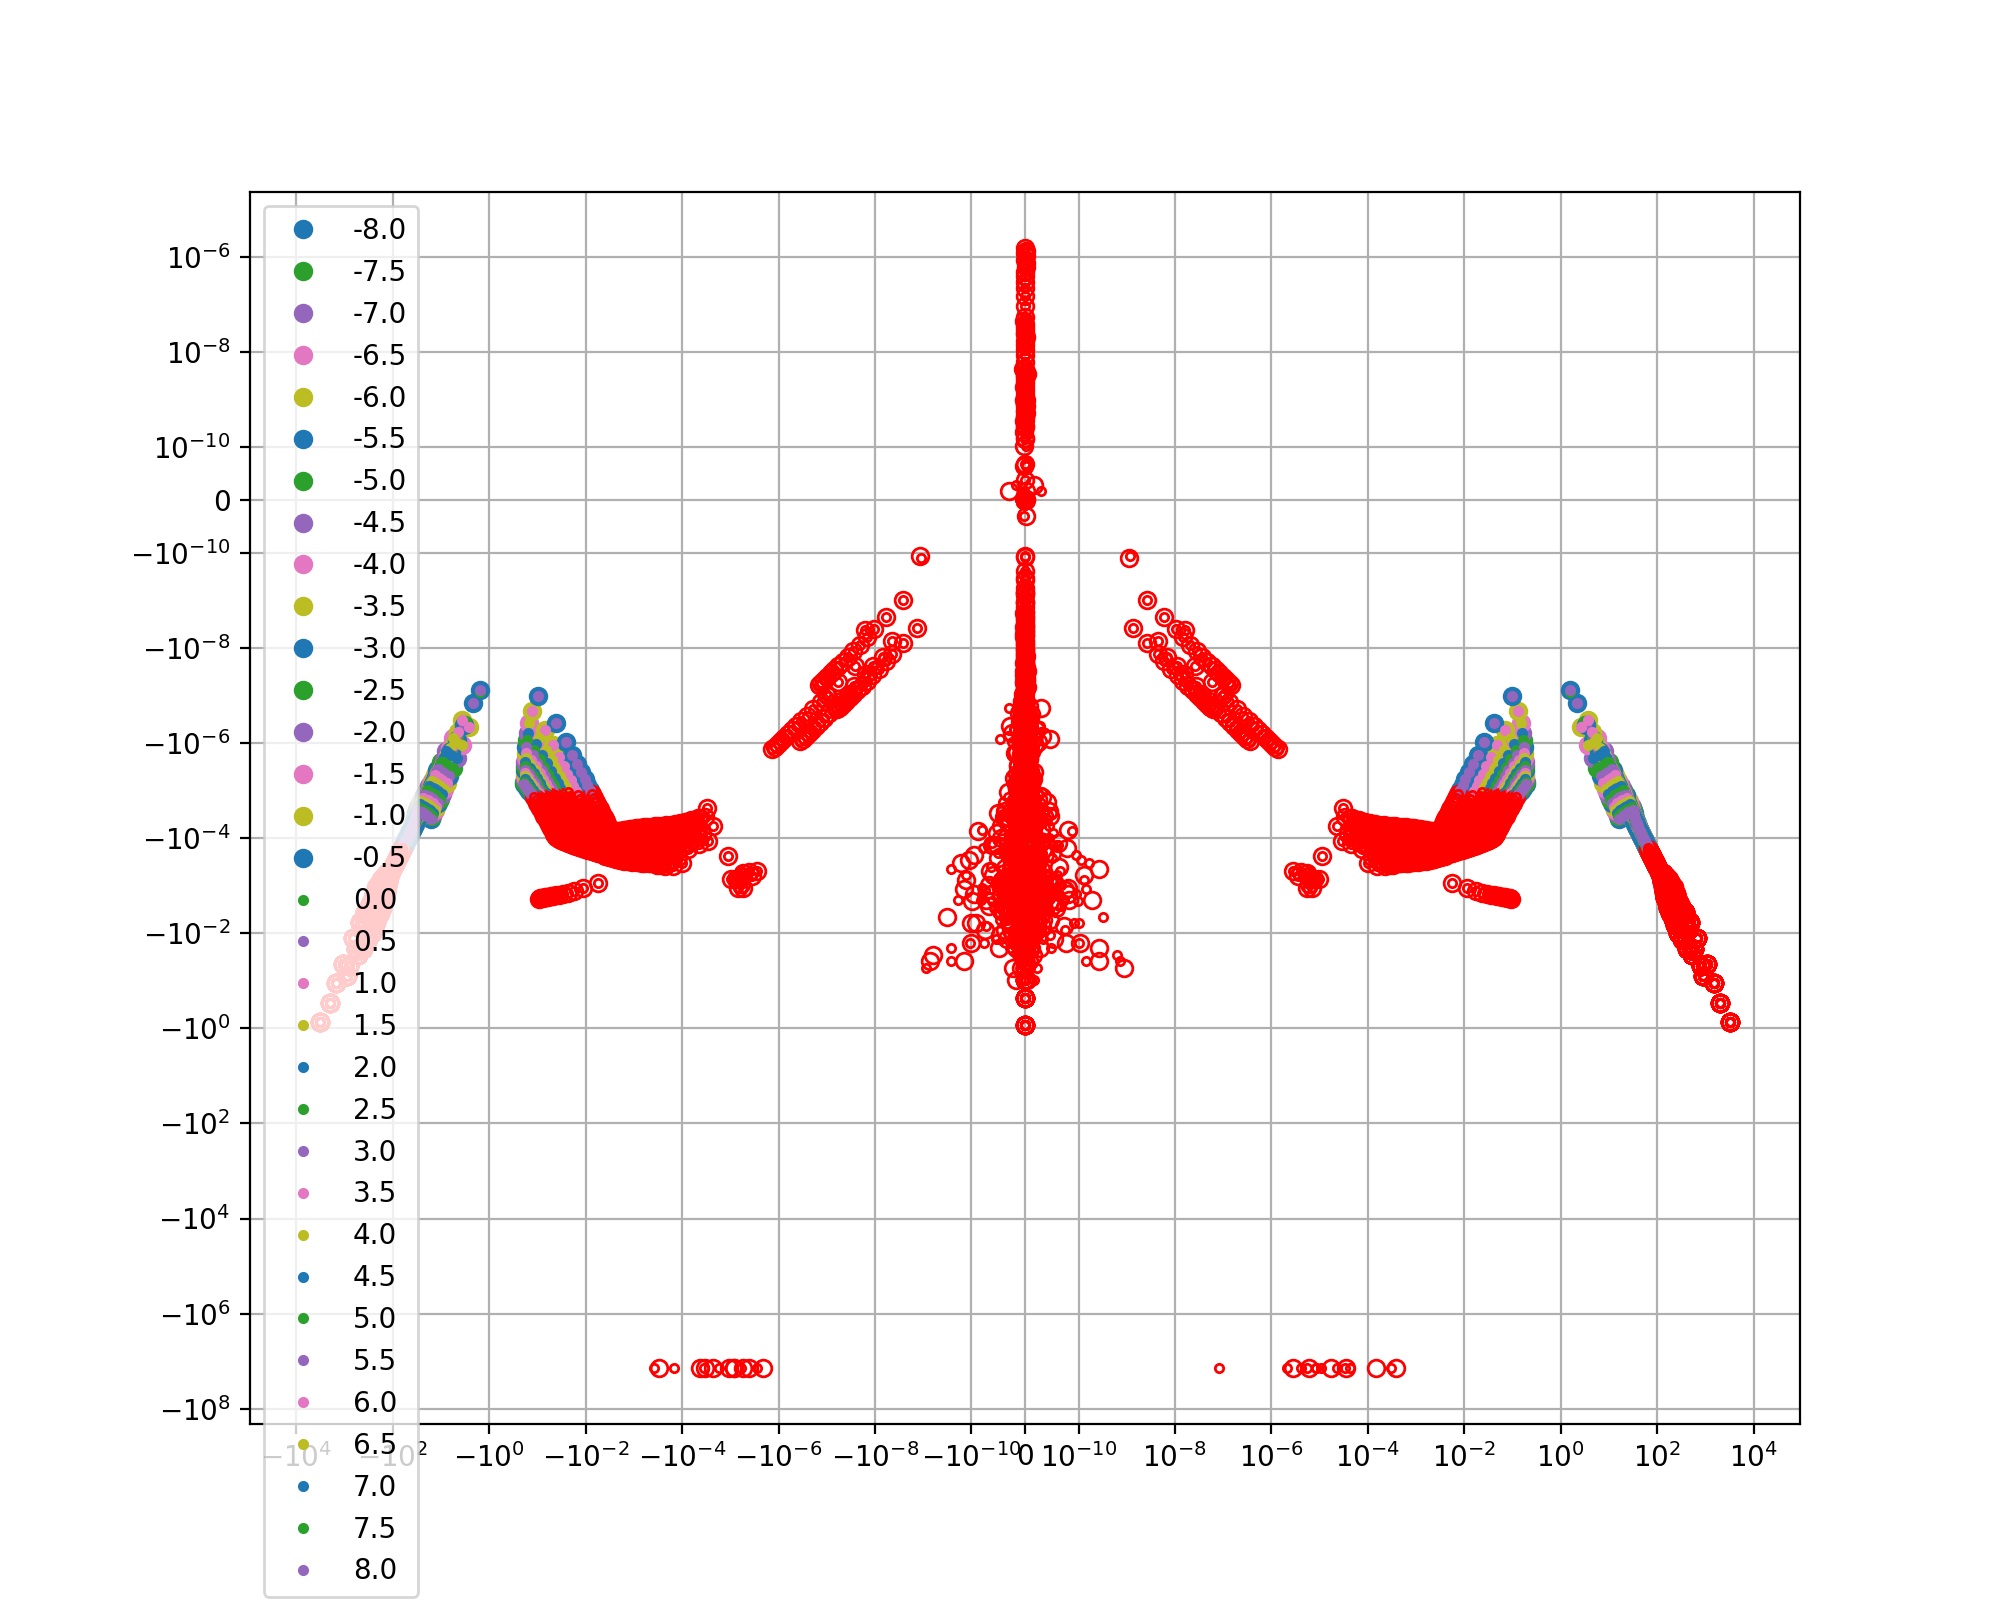

{-8.0: 88,
 -7.5: 90,
 -7.0: 92,
 -6.5: 94,
 -6.0: 96,
 -5.5: 96,
 -5.0: 96,
 -4.5: 100,
 -4.0: 100,
 -3.5: 100,
 -3.0: 102,
 -2.5: 102,
 -2.0: 102,
 -1.5: 104,
 -1.0: 106,
 -0.5: 106,
 0.0: 140,
 0.5: 106,
 1.0: 106,
 1.5: 104,
 2.0: 102,
 2.5: 102,
 3.0: 102,
 3.5: 100,
 4.0: 100,
 4.5: 100,
 5.0: 96,
 5.5: 96,
 6.0: 96,
 6.5: 94,
 7.0: 92,
 7.5: 90,
 8.0: 88}

In [107]:
krel_list = np.arange(-8, 8.1, 0.5)
shortmodes = modes.get_modes(param, krel_list, verbose=False)

N = {}
plt.figure(figsize=(10,8))
for krel in krel_list:
    freqs = 1j * shortmodes[krel][0]
    filt = gen_filt(freqs, krel)
    N[krel] = np.sum(filt)
    scale = 1
    if krel < 0:
        plt.plot(freqs[filt].real*scale, freqs[filt].imag, 'o', label=str(krel))
        plt.plot(freqs[~filt].real*scale, freqs[~filt].imag, 'o', mfc='none', mec='r')
    else:
        plt.plot(freqs[filt].real*scale, freqs[filt].imag, '.', label=str(krel))
        plt.plot(freqs[~filt].real*scale, freqs[~filt].imag, '.', mfc='none', mec='r')
plt.xscale('symlog', linthreshx=1e-10)
plt.yscale('symlog', linthreshy=1e-10)
plt.grid()
plt.legend(loc='upper left')
N

Loading modes krel=1.5
Loading modes krel=-1.5
0.0


<IPython.core.display.Javascript object>


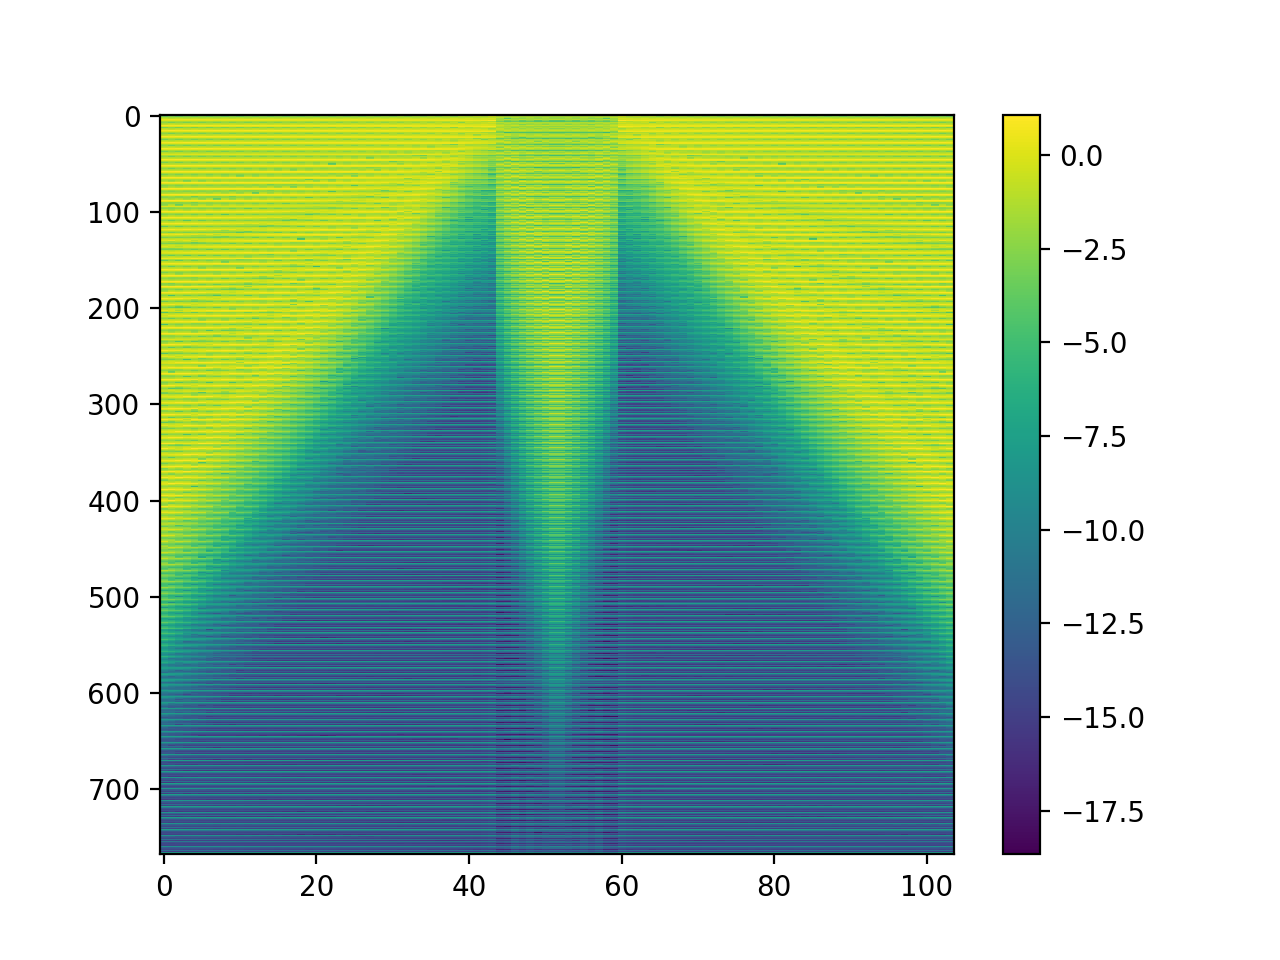

In [34]:
krel = 1.5
shortmodes = modes.get_modes(param, [krel, -krel])
evals_p = shortmodes[krel][0]
evals_m = shortmodes[-krel][0]
filt_p = gen_filt(1j*evals_p, krel)
filt_m = gen_filt(1j*evals_m, -krel)
evecs_p = shortmodes[krel][1]
evecs_m = shortmodes[-krel][1]

def phase(X):
    return X / np.abs(X)

evecs_p /= phase(evecs_p[0:1,:])
evecs_m /= phase(evecs_m[0:1,:])

evec_diff = evecs_p[:,filt_p]-evecs_m[:,filt_m][:,::-1].conj()
print(np.max(np.abs(evec_diff)))

plt.figure()
plt.imshow(np.log10(np.abs(evecs_p[:,filt_p])), aspect='auto')
plt.colorbar()

## Check mode symmetries

In [39]:
krel_list = np.arange(0.5, 10.1, 0.5)
errors = {}
        
for krel in krel_list:
    shortmodes = modes.get_modes(param, [-krel, krel], verbose=False)
    evals_p, evecs_p, adj_evals_p, adj_evecs_p, proj_p = shortmodes[krel]
    evals_n, evecs_n, adj_evals_n, adj_evecs_n, proj_n = shortmodes[-krel]
    filt_p = gen_filt(1j*evals_p, krel)
    filt_n = gen_filt(1j*evals_n, -krel)
    eval_error = np.max(np.abs(evals_p[filt_p] - evals_n[filt_n][::-1].conj()))
    evec_error = np.max(np.abs(evecs_p[:,filt_p] - evecs_n[:,filt_n][:,::-1].conj()))
    evec_mag_error = np.max(np.abs(evecs_p[:,filt_p]) - np.abs(evecs_n[:,filt_n][:,::-1].conj()))
    metric_p = (proj_p @ evecs_p)[filt_p,:][:,filt_p]
    metric_n = (proj_n @ evecs_n)[filt_n,:][:,filt_n]
    metric_p_error = np.max(np.abs(metric_p - np.eye(*metric_p.shape)))
    metric_n_error = np.max(np.abs(metric_n - np.eye(*metric_n.shape)))
    errors[krel] = [eval_error, evec_error, evec_mag_error, metric_p_error, metric_n_error]

In [40]:
import pandas as pd
data = pd.DataFrame(errors)
data.T

,0,1,2,3,4
0.5,0.0,0.0,0.0,4.232352e-13,4.232352e-13
1.0,0.0,0.0,0.0,3.169241e-13,3.169241e-13
1.5,0.0,0.0,0.0,1.924376e-13,1.924376e-13
2.0,0.0,0.0,0.0,3.040266e-13,3.040266e-13
2.5,0.0,0.0,0.0,2.405527e-13,2.405527e-13
3.0,0.0,0.0,0.0,2.764209e-13,2.764209e-13
3.5,0.0,0.0,0.0,1.473842e-13,1.473842e-13
4.0,0.0,0.0,0.0,1.557821e-13,1.557821e-13
4.5,0.0,0.0,0.0,1.221806e-13,1.221806e-13
5.0,0.0,0.0,0.0,1.456639e-13,1.456639e-13


## Mode-mode coupling coefficients

In [10]:
state_b = dev.system.FieldSystem(problem.variables, domain)
state_c = dev.system.FieldSystem(problem.variables, domain)
filename = lambda krel_b, krel_c: "coupling/coupling_%i_%.1f_%.1f.pkl" %(param.Nz, krel_b, krel_c)

def save_coupling(krel_b, krel_c, tqdm_kw={}, filename=filename):
    print("Saving coupling krel_b=%.1f krel_c=%.1f" %(krel_b, krel_c))
    # Get b pencil data
    p_b = get_pencil(krel_b)
    evals_b, evecs_b, adj_evals_b, adj_evecs_b, proj_b = shortmodes[krel_b]
    filt_b = gen_filt(1j*evals_b, krel_b)
    N_b = np.sum(filt_b)
    # Get c pencil data
    p_c = get_pencil(krel_c)
    evals_c, evecs_c, adj_evals_c, adj_evecs_c, proj_c = shortmodes[krel_c]
    filt_c = gen_filt(1j*evals_c, krel_c)
    N_c = np.sum(filt_c)
    # Get a pencil data
    krel_a = krel_b + krel_c
    p_a = get_pencil(krel_a)
    evals_a, evecs_a, adj_evals_a, adj_evecs_a, proj_a = shortmodes[krel_a]
    filt_a = gen_filt(1j*evals_a, krel_a)
    N_a = np.sum(filt_a)
    # Compute coupling coefficients
    K_abc = np.zeros((N_a, N_b, N_c), dtype=np.complex128)
    desc = "krel_b=%.1f, krel_c=%.1f, nb:" %(krel_b, krel_c)
    for nb in tqdm(range(N_b), desc=desc, **tqdm_kw):
        # Set b state
        state_b.data[:] = 0
        state_b.set_pencil(p_b, evecs_b[:,filt_b][:,nb])
        state_b.scatter()
        for nc in range(N_c):
            # Set c state
            state_c.data[:] = 0
            state_c.set_pencil(p_c, evecs_c[:,filt_c][:,nc])
            state_c.scatter()
            # Compute DF
            compute_dF(state_b, state_c)
            # Compute coefficients
            K_abc[:, nb, nc] = adj_evecs_a[:,filt_a].conj().T @ dF.get_pencil(p_a)
    pickle.dump(K_abc, open(filename(krel_b, krel_c), "wb"))
    
def load_coupling(krel_b, krel_c, filename=filename):
    print("Loading coupling krel_b=%.1f krel_c=%.1f" %(krel_b, krel_c))
    return pickle.load(open(filename(krel_b, krel_c), "rb"))

def get_coupling(krel_b_list, dk_list, force=False, filename=filename):
    K_abc_dict = {}
    for krel_b in krel_b_list:
        for dk in dk_list:
            krel_c = krel_b + dk
            if force or (not pathlib.Path(filename(krel_b, krel_c)).exists()):
                save_coupling(krel_b, krel_c)
            K_abc_dict[(krel_b, krel_c)] = load_coupling(krel_b, krel_c)
    return K_abc_dict

In [28]:
K_abc_dict = get_coupling([1], [1])

Loading coupling krel_b=1.0 krel_c=2.0


In [31]:
K_abc_dict[(1,2)].shape

(190, 192, 190)

<IPython.core.display.Javascript object>


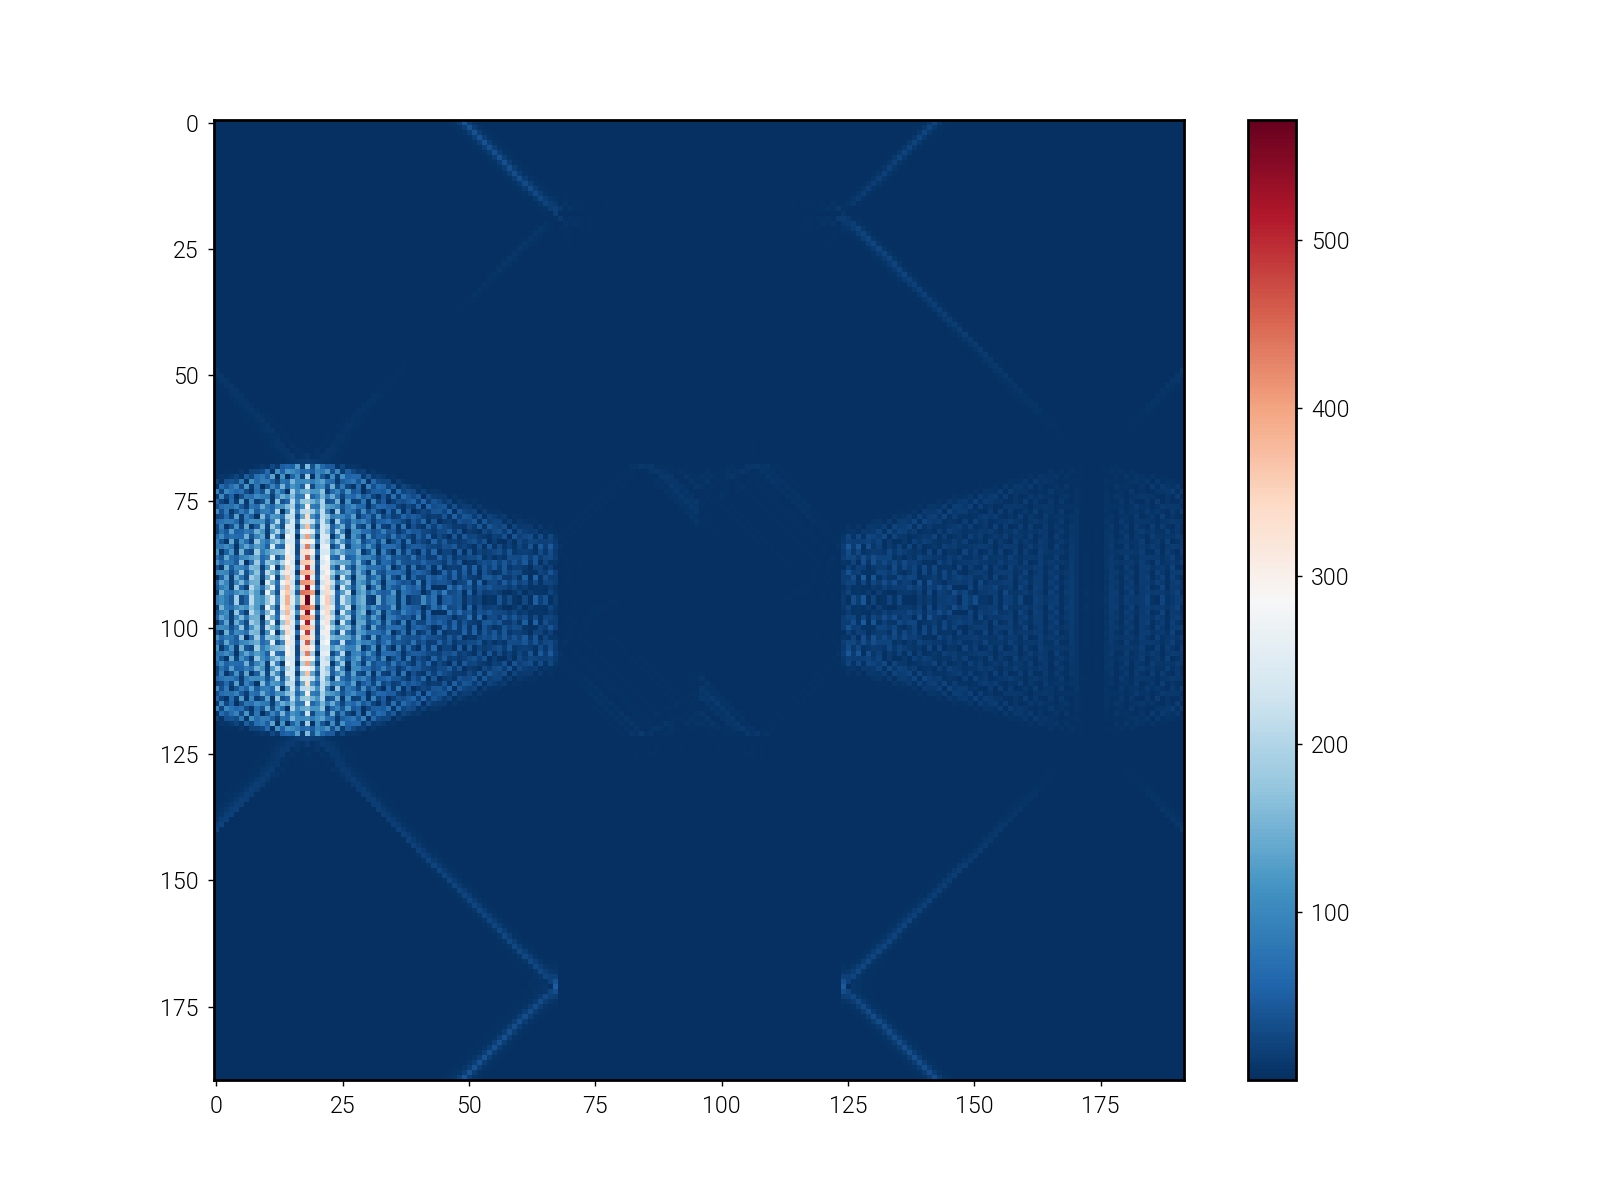

In [75]:
phase = lambda Z: np.arctan2(Z.imag, Z.real)

plt.figure()
plt.imshow(np.abs(K_abc_dict[(1,2)][:,:,18]))
plt.colorbar()

## Tide-mode coupling coefficients

In [59]:
filename = lambda krel_c: "coupling/coupling_%i_tide_%.1f.pkl" %(param.Nz, krel_c)

def save_tm_coupling(krel_c, tqdm_kw={}, filename=filename):
    """Compute and save tide-mode coupling matrices."""
    print("Saving tm coupling krel_c=%.1f" %(krel_c))
    shortmodes = modes.get_modes(param, [krel_c, krel_c+1, krel_c-1], verbose=False)
    # Get c pencil data
    p_c = get_pencil(krel_c)
    evals_c, evecs_c, adj_evals_c, adj_evecs_c, proj_c = shortmodes[krel_c]
    filt_c = gen_filt(1j*evals_c, krel_c)
    N_c = np.sum(filt_c)
    # Compute coupling coefficients
    state_c = dev.system.FieldSystem(ivp_problem.variables, ivp_domain)
    K_aLc_dict = {}
    desc = "krel_c=%.1f, nc:" %(krel_c)
    for nc in tqdm(range(N_c), desc=desc, **tqdm_kw):
        # Set c state
        state_c.data[:] = 0
        state_c.set_pencil(p_c, evecs_c[:,filt_c][:,nc])
        state_c.scatter()
        # Compute DF
        compute_dF(X_linear_tide, state_c)
        for krel_tide in [-1, 1]:
            # Get a pencil data
            krel_a = krel_tide + krel_c
            p_a = get_pencil(krel_a)
            evals_a, evecs_a, adj_evals_a, adj_evecs_a, proj_a = shortmodes[krel_a]
            filt_a = gen_filt(1j*evals_a, krel_a)
            N_a = np.sum(filt_a)
            # Build coupling coefficient matrix
            if (krel_a, krel_c) not in K_aLc_dict:
                K_aLc = np.zeros((N_a, N_c), dtype=np.complex128)
                K_aLc_dict[(krel_a, krel_c)] = K_aLc
            else:
                K_aLc = K_aLc_dict[(krel_a, krel_c)]
            # Compute coupling coefficients
            K_aLc[:,nc] = adj_evecs_a[:,filt_a].conj().T @ dF.get_pencil(p_a)
    pickle.dump(K_aLc_dict, open(filename(krel_c), "wb"))
    
def load_tm_coupling(krel_c, filename=filename):
    """Load tide-mode coupling matrices."""
    print("Loading tm coupling krel_c=%.1f" %(krel_c))
    return pickle.load(open(filename(krel_c), "rb"))

def get_tm_coupling(krel_c_list, force=False, filename=filename, **kw):
    """Get tide-mode coupling matrices."""
    K_aLc_dict = {}
    for krel_c in krel_c_list:
        # Compute couplings
        if force or (not pathlib.Path(filename(krel_c)).exists()):
            save_tm_coupling(krel_c, **kw)
        # Load couplings
        K_aLc_dict.update(load_tm_coupling(krel_c))
    return K_aLc_dict

In [61]:
def pool_tm_coupling(args):
    tqdm_kw = {'leave': True}
    get_tm_coupling(args, tqdm_kw=tqdm_kw, force=True)
    
krel_c_list = np.arange(-8, 8.1, 1)
pool_tm_args = [[krel_c] for krel_c in krel_c_list]

poolsize = 4
pool = Pool(poolsize)
pool.imap_unordered(pool_tm_coupling, pool_tm_args)
pool.close()

Saving tm coupling krel_c=-7.0
Saving tm coupling krel_c=-8.0
Saving tm coupling krel_c=-6.0
Saving tm coupling krel_c=-5.0



Loading tm coupling krel_c=-8.0
Saving tm coupling krel_c=-4.0



Loading tm coupling krel_c=-7.0
Saving tm coupling krel_c=-3.0



Loading tm coupling krel_c=-5.0
Saving tm coupling krel_c=-2.0

Loading tm coupling krel_c=-6.0
Saving tm coupling krel_c=-1.0



Loading tm coupling krel_c=-4.0
Saving tm coupling krel_c=0.0



Loading tm coupling krel_c=-3.0
Saving tm coupling krel_c=1.0



Loading tm coupling krel_c=-2.0
Saving tm coupling krel_c=2.0



Loading tm coupling krel_c=-1.0
Saving tm coupling krel_c=3.0



Loading tm coupling krel_c=2.0
Saving tm coupling krel_c=4.0



Loading tm coupling krel_c=1.0
Saving tm coupling krel_c=5.0



Loading tm coupling krel_c=3.0
Saving tm coupling krel_c=6.0



Loading tm coupling krel_c=0.0
Saving tm coupling krel_c=7.0



Loading tm coupling krel_c=5.0
Saving tm coupling krel_c=8.0



Loading tm coupling krel_c=4.0

Loading tm coupling krel_c=6.0

Loading tm coupling krel_c=7.0

Loading tm coupling krel_c=8.0


In [62]:
pool.join()

## Examine coupling coefficients

In [108]:
K_aLc_dict = get_tm_coupling([-1,1,2])

# Check symmetry
K1 = K_aLc_dict[(2,1)]
K2 = K_aLc_dict[(-2,-1)]
K3 = K_aLc_dict[(1,2)]

print(np.allclose(K1, K2[::-1,::-1].conj()))
print(np.max(np.abs(K1 - K2[::-1,::-1].conj())))

Loading tm coupling krel_c=-1.0
Loading tm coupling krel_c=1.0
Loading tm coupling krel_c=2.0
True
0.0


<IPython.core.display.Javascript object>


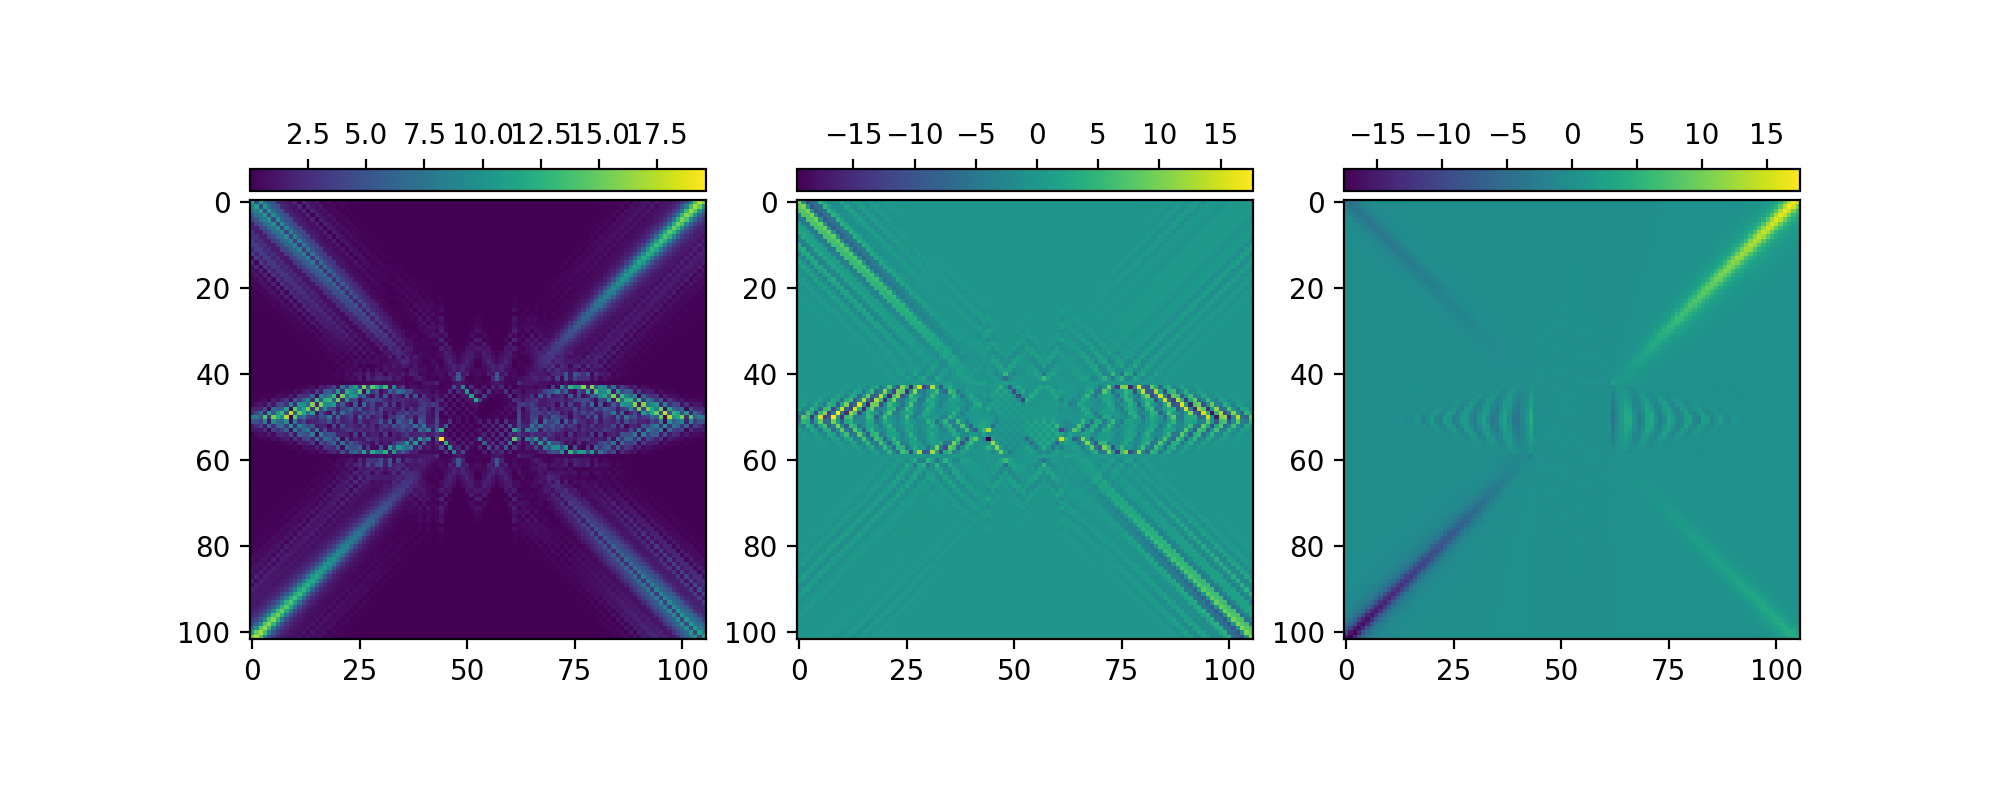

<IPython.core.display.Javascript object>


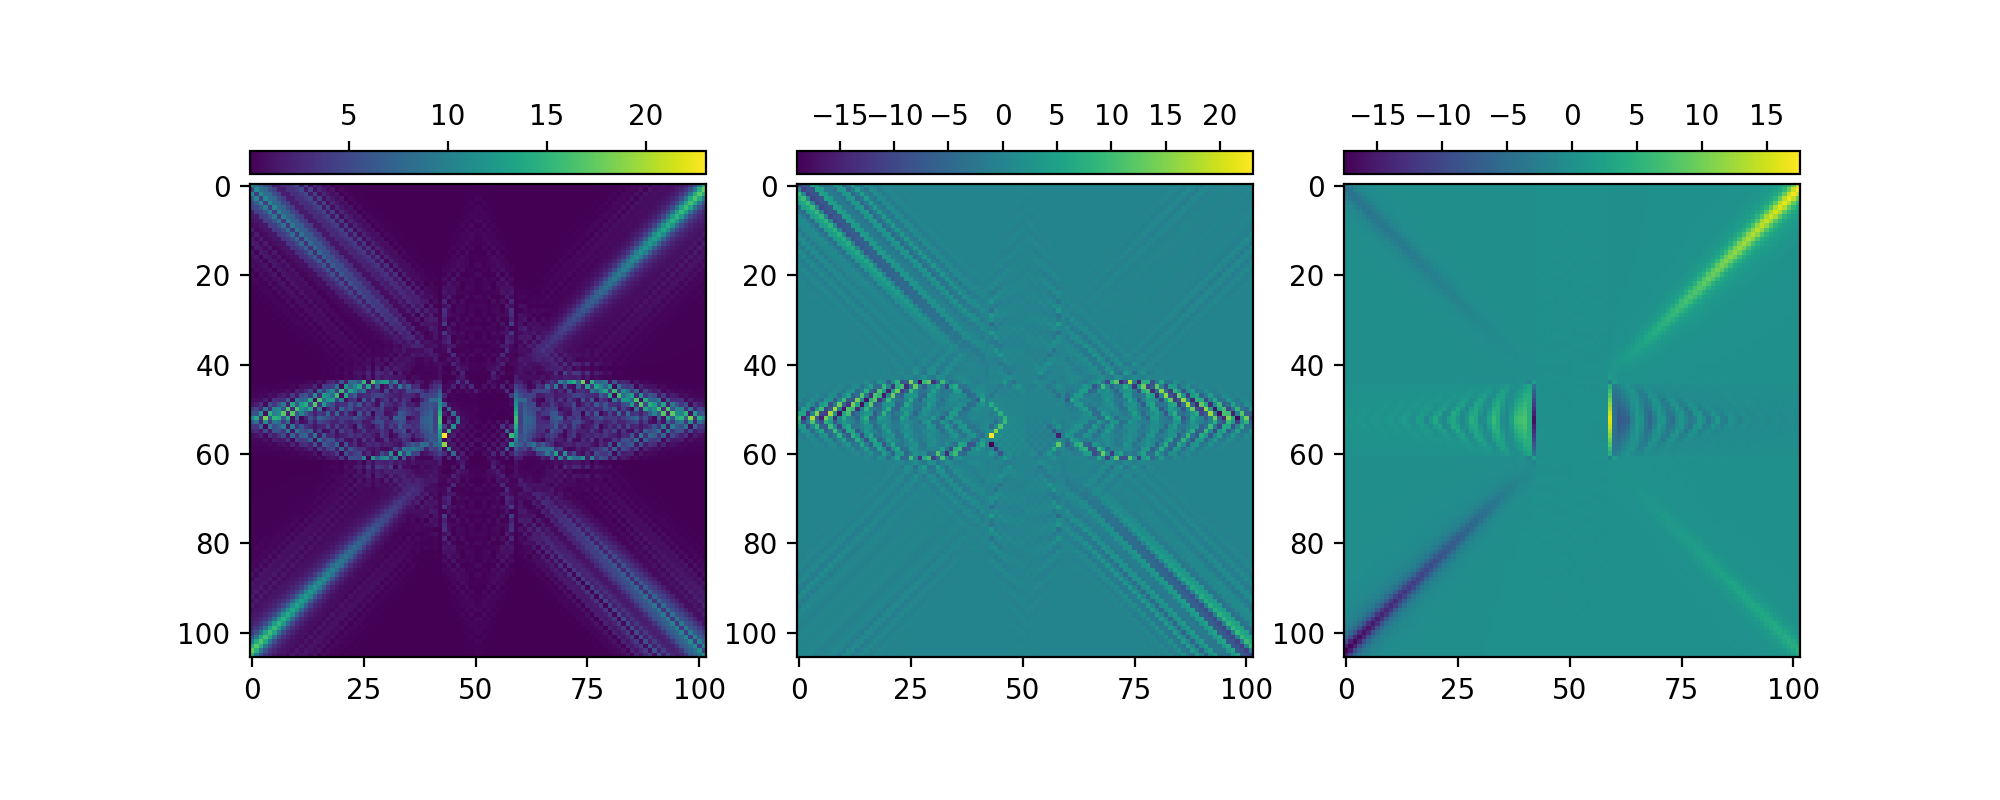

In [109]:
def nice_colorbar(ax, im):
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("top", size="5%", pad="2%")
    plt.colorbar(im, cax=cax, orientation="horizontal")
    cax.xaxis.set_ticks_position("top")

plt.figure(figsize=(10,4))
ax = plt.subplot(1,3,1)
im = ax.imshow(np.abs(K1))
nice_colorbar(ax, im)
ax = plt.subplot(1,3,2)
im = ax.imshow(np.real(K1))
nice_colorbar(ax, im)
ax = plt.subplot(1,3,3)
im = ax.imshow(np.imag(K1))
nice_colorbar(ax, im)

plt.figure(figsize=(10,4))
ax = plt.subplot(1,3,1)
im = ax.imshow(np.abs(K3))
nice_colorbar(ax, im)
ax = plt.subplot(1,3,2)
im = ax.imshow(np.real(K3))
nice_colorbar(ax, im)
ax = plt.subplot(1,3,3)
im = ax.imshow(np.imag(K3))
nice_colorbar(ax, im)

Loading tm coupling krel_c=8.0


<IPython.core.display.Javascript object>


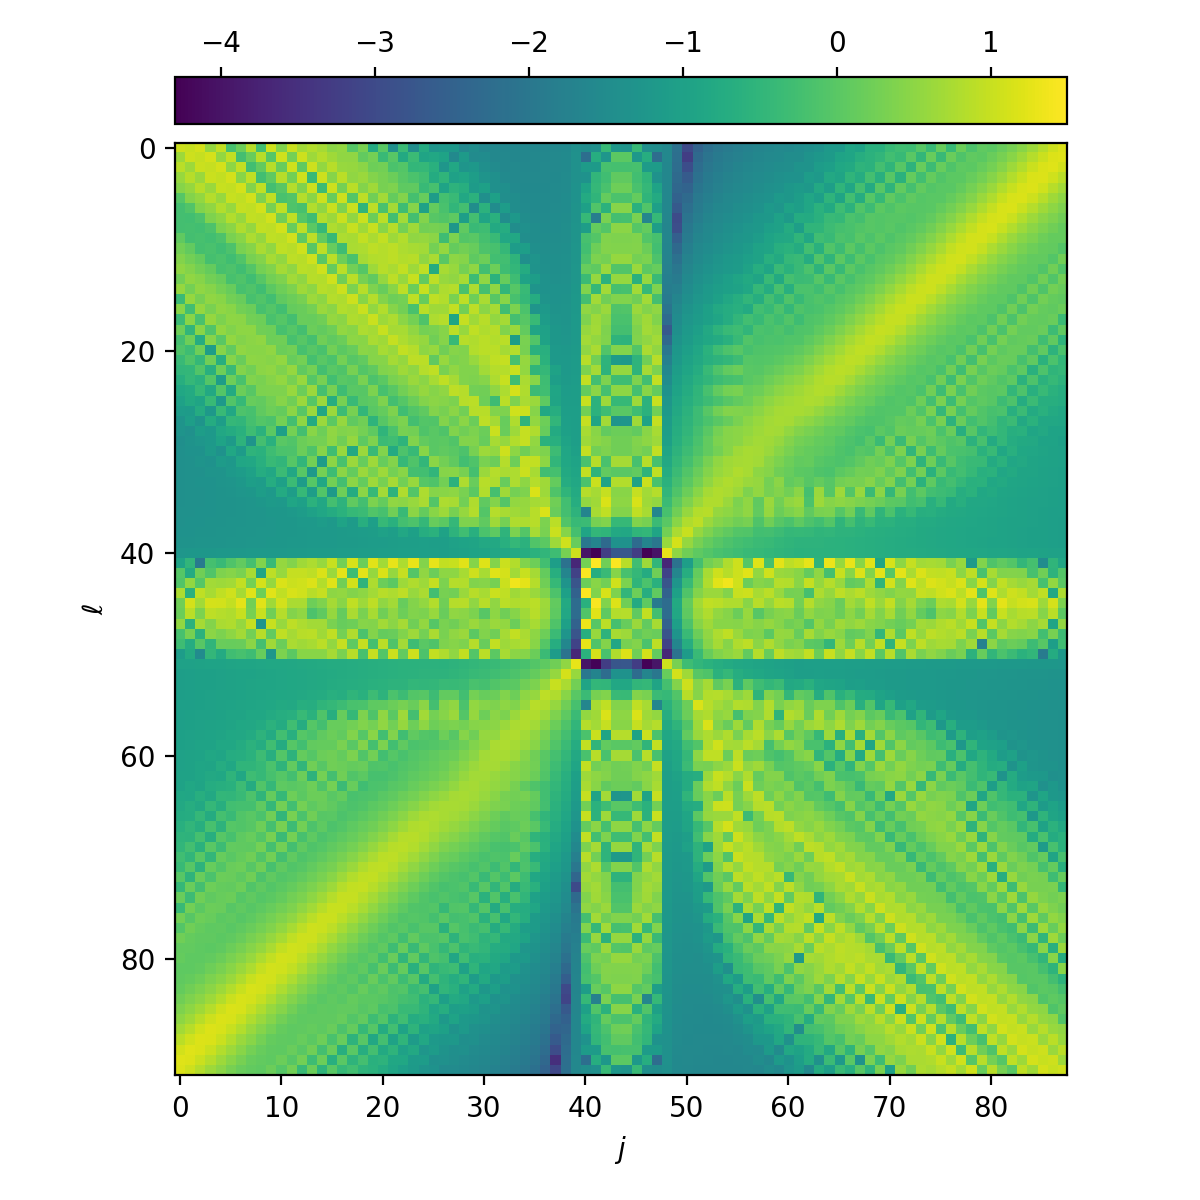

In [112]:
#plt.style.use('thesis')

K_aLc_dict = get_tm_coupling([8])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
im = ax.imshow(np.log10(np.abs(K_aLc_dict[(7,8)])), cmap='viridis', rasterized=True)
nice_colorbar(ax, im)

ax.set_ylabel(r'$\ell$')
ax.set_xlabel(r'$j$')
cax.set_title(r'$\log_{10} |C_{k,\ell,n,j}|$', pad=20)
fig.tight_layout()

In [105]:
def build_Q(A, krel_list):
    shortmodes = modes.get_modes(param, krel_list)
    K_aLc_dict = get_tm_coupling(krel_list)
    Q = []
    for ka in krel_list:
        Qa = []
        for kc in krel_list:
            if (ka, kc) in K_aLc_dict:
                Qac = A * K_aLc_dict[(ka,kc)]
            else:
                Qac = np.zeros((N[ka], N[kc]), dtype=np.complex128)
            if ka == kc:
                evals = shortmodes[ka][0]
                filt = gen_filt(1j*evals, ka)
                # Shift frequencies into comoving frame where tide is time-independent
                Qaa = np.diag(evals[filt] - (-1j*ka*param.ω_tide))
                Qac += Qaa
            Qa.append(Qac)
            print(Qac.shape)
        Q.append(Qa)
    return np.block(Q)

Loading modes krel=-2.0
Loading modes krel=-1.0
Loading modes krel=0.0
Loading modes krel=1.0
Loading modes krel=2.0
Loading tm coupling krel_c=-2.0
Loading tm coupling krel_c=-1.0
Loading tm coupling krel_c=0.0
Loading tm coupling krel_c=1.0
Loading tm coupling krel_c=2.0
(102, 102)
(102, 106)
(102, 140)
(102, 106)
(102, 102)
(106, 102)
(106, 106)
(106, 140)
(106, 106)
(106, 102)
(140, 102)
(140, 106)
(140, 140)
(140, 106)
(140, 102)
(106, 102)
(106, 106)
(106, 140)
(106, 106)
(106, 102)
(102, 102)
(102, 106)
(102, 140)
(102, 106)
(102, 102)


<IPython.core.display.Javascript object>


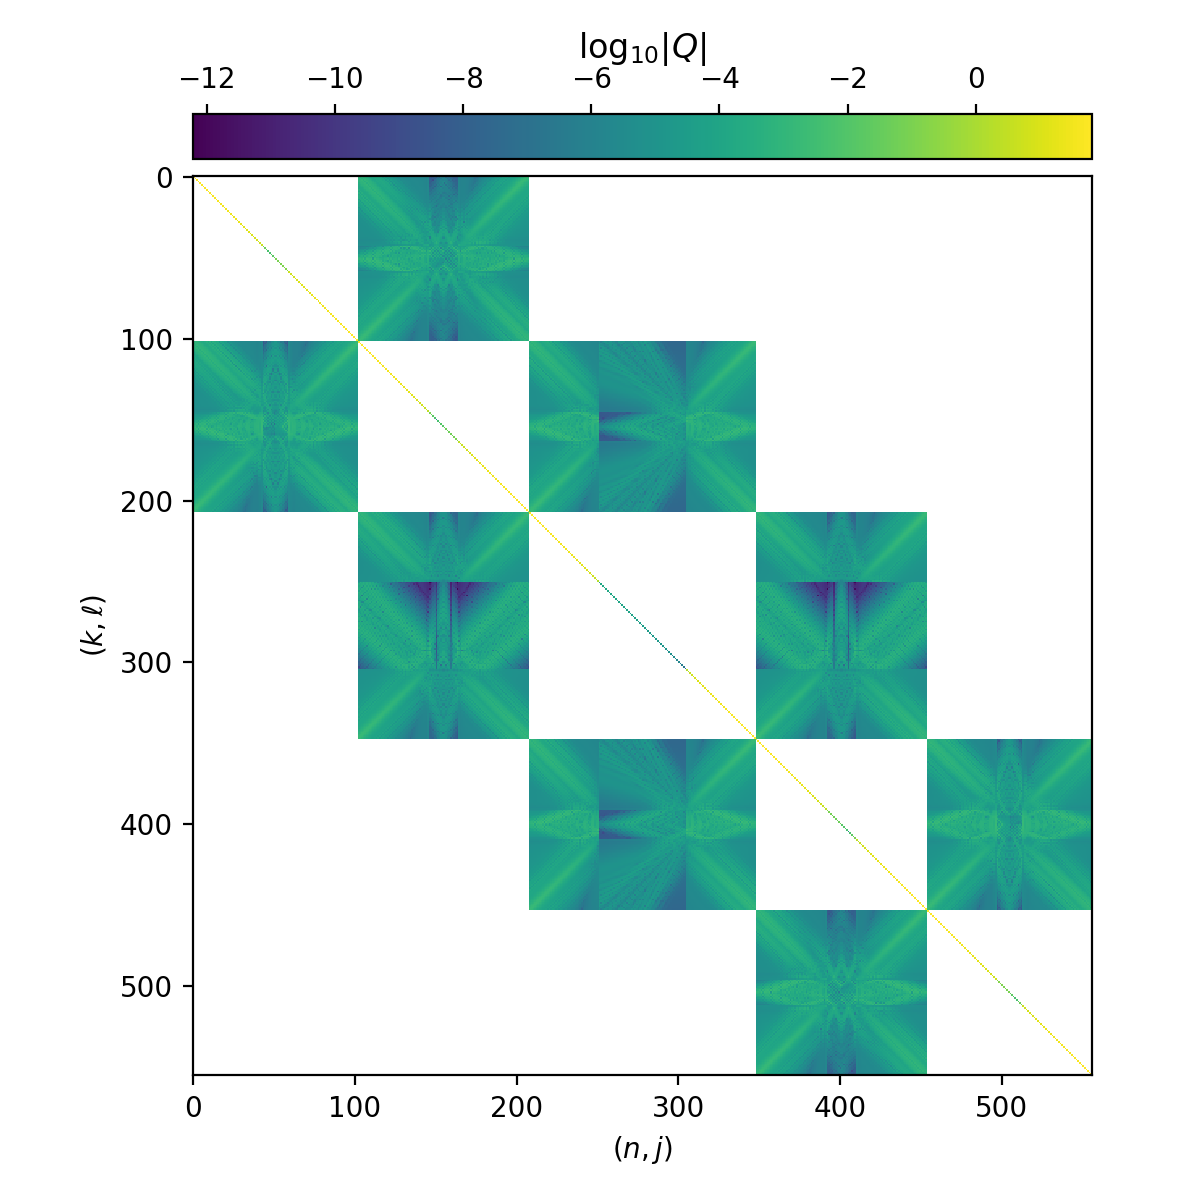

/Users/kburns/Software/miniconda3/envs/dedalus-mkl/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


In [124]:
# Build eigenmode-time-evolution matrix Q
A = 1e-4
krel_list = np.arange(-3, 3+0.005, 0.5)
krel_list = [-2,-1,0,1,2]
Q = build_Q(A, krel_list)

# Plot Q
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
im = ax.imshow(np.log10(np.abs(Q)), cmap='viridis')

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="5%", pad="2%")
plt.colorbar(im, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")

ax.set_xlabel(r'$(n,j)$')
ax.set_ylabel(r'$(k,\ell)$')
cax.set_title(r'$\log_{10} |Q|$', pad=20)
fig.tight_layout()
#plt.savefig('coupling_many.pdf')

In [125]:
# Find eigenmodes of Q
Q_evals, Q_evecs = linalg.eig(Q)
Q_freqs = 1j * Q_evals

<IPython.core.display.Javascript object>


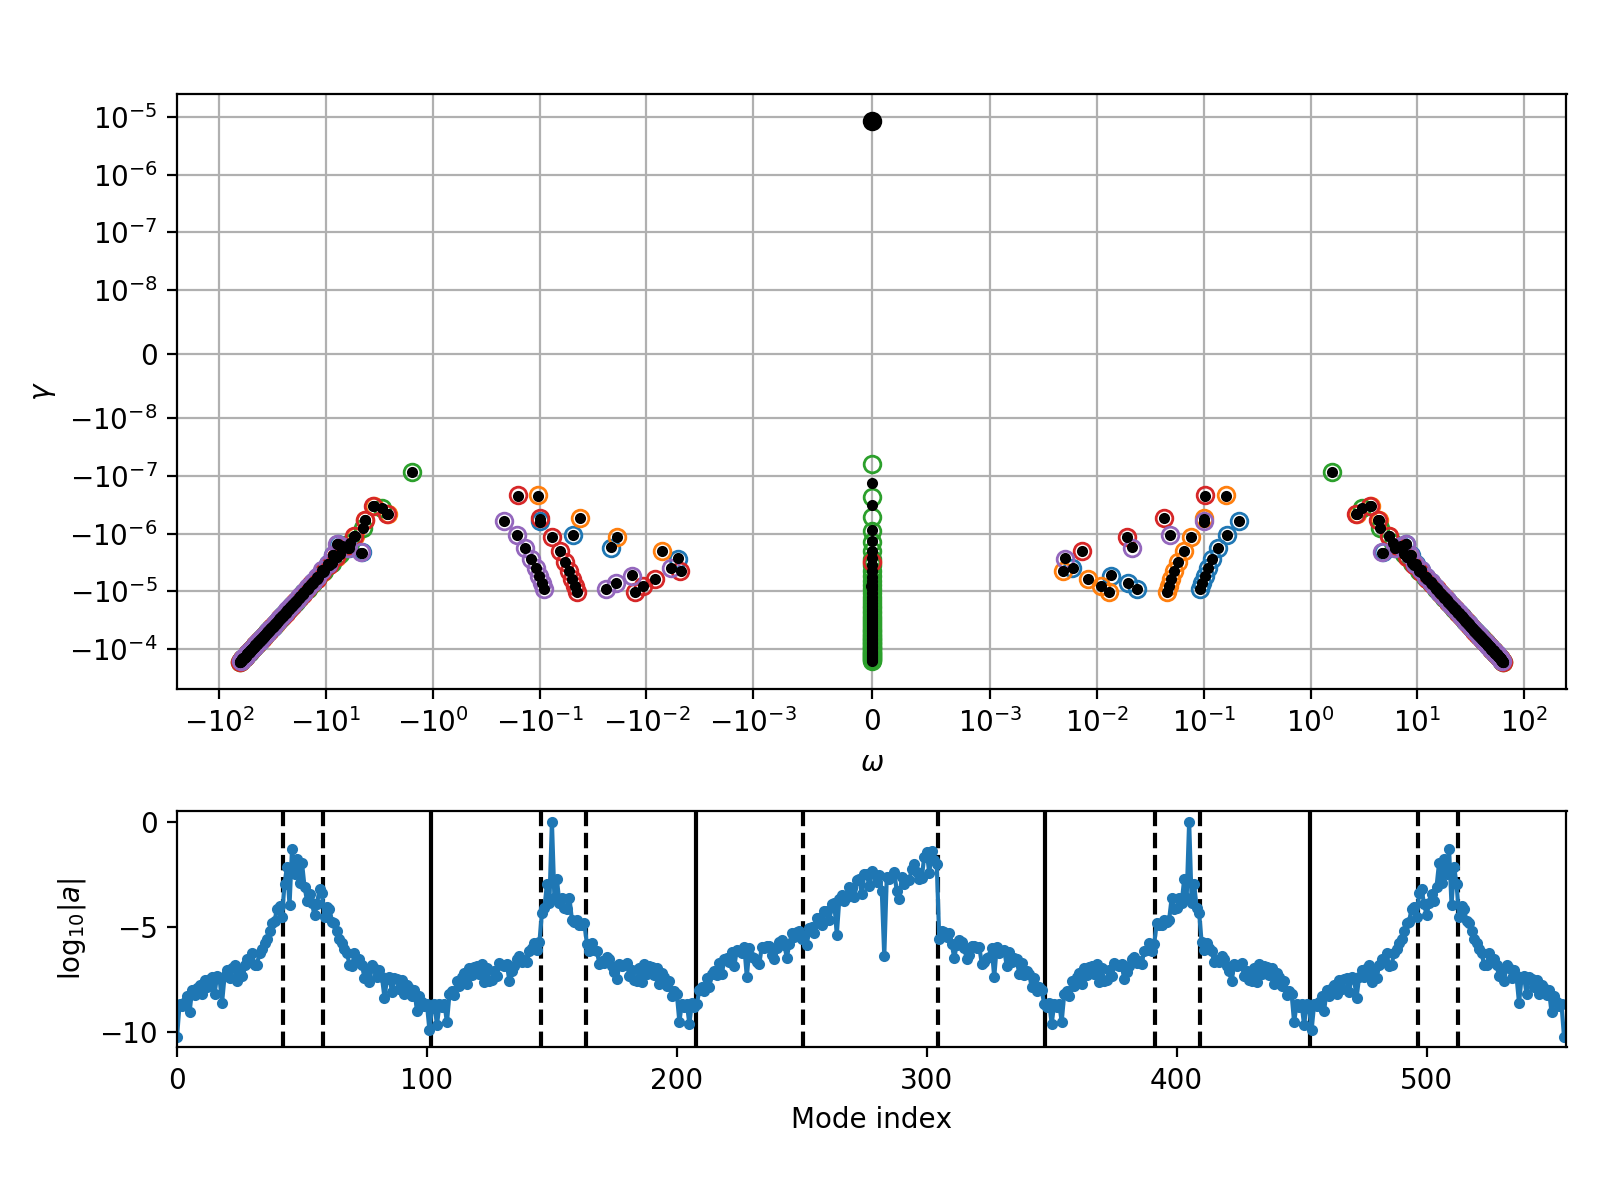

7

In [126]:
item = 1

# Plot eigenvalues of Q
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2)
for krel in krel_list:
    freqs = 1j * shortmodes[krel][0]
    filt = gen_filt(freqs, krel)
    ax1.plot(freqs[filt].real-krel*param.ω_tide, freqs[filt].imag, 'o', mfc='none')
plt_Q, = ax1.plot(Q_freqs.real, Q_freqs.imag, '.k', picker=2)
ax1.set_xscale('symlog', linthreshx=1e-3)
ax1.set_yscale('symlog', linthreshy=1e-8)
ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$\gamma$')
plt.grid()
active_dot, = ax1.plot(0, 0, 'ok')
active_ev = fig.suptitle('')

# Plot mode separations
ax2 = plt.subplot2grid((3,1), (2,0))
def plot_seps():
    n = 0
    for krel in krel_list:
        # Block separator
        if krel != krel_list[0]:
            ax2.axvline(item*n-0.5, c='k', zorder=-1)
        # P-G separator
        freqs = 1j * shortmodes[krel][0]
        filt = gen_filt(freqs, krel)
        ni = np.sum(freqs[filt].real < -1)
        ax2.axvline(item*n+item*ni-0.5, c='k', ls='dashed', zorder=-1)
        ni = np.sum(freqs[filt].real < 1)
        ax2.axvline(item*n+item*ni-0.5, c='k', ls='dashed', zorder=-1)
        n += N[krel]
    ax2.set_xlim(0, item*n)
    #ax2.set_ylim(-15,0)
    ax2.set_xlabel('Mode index')
    ax2.set_ylabel(r'$\log_{10} |a|$')

def plot_mode(event):
    # Update active eigenvalue
    Xm, Ym = event.mouseevent.x, event.mouseevent.y
    x = plt_Q.get_xdata()
    y = plt_Q.get_ydata()
    XY = ax1.transData.transform(np.array([x,y]).T)
    dXY = XY - np.array([Xm, Ym])
    D = np.sum(dXY**2, axis=1)
    index = np.argmin(D)
    freq = Q_freqs[index]
    active_dot.set_xdata([x[index]])
    active_dot.set_ydata([y[index]])
    #active_ev.set_text('%i: %s' %(index, freq))
    # Plot mode
    ax2.cla()
    evec = Q_evecs[:,index]
    evec = evec / np.max(np.abs(evec))
    ax2.plot(np.log10(np.abs(evec)), '.-')
    plot_seps()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.canvas.mpl_connect('pick_event', plot_mode)

In [145]:
plt.savefig('Q_spectrum.pdf')

2018-05-25 02:14:01,037 matplotlib.backends.backend_pdf 0/1 DEBUG :: Assigning font /b'F1' = '/Library/Fonts/Roboto-Medium.ttf'
2018-05-25 02:14:01,198 matplotlib.backends.backend_pdf 0/1 DEBUG :: Assigning font /b'F2' = '/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf'
2018-05-25 02:14:01,646 matplotlib.backends.backend_pdf 0/1 DEBUG :: Assigning font /b'F3' = '/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf'
2018-05-25 02:14:01,718 matplotlib.backends.backend_pdf 0/1 DEBUG :: Embedding font /Library/Fonts/Roboto-Medium.ttf.
2018-05-25 02:14:01,719 matplotlib.backends.backend_pdf 0/1 DEBUG :: Writing TrueType font.
2018-05-25 02:14:01,727 matplotlib.backends.backend_pdf 0/1 DEBUG :: Embedding font /usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf.
2018-05-25 02:14:01,728 matplotlib.backends.backend_pdf 0/1 DEBUG :: Writing TrueType font.
2018-05-25 02:14:01,736 matplotlib

In [28]:
from scipy import sparse
from scipy.sparse import linalg as spla

# Threshold
krel_list = np.arange(-2, 2+0.05, 0.5)
A_list = 10**np.linspace(-6,-3,8)

smax_list = []
smax_sp_list = []
for A in A_list:
    print(A)
    Q = build_Q(A, krel_list)
    Q_evals, Q_evecs = linalg.eig(Q)
    smax = np.max(Q_evals.real)
    smax_list.append(smax)
    #Q_evals, Q_evecs = spla.eigs(sparse.csr_matrix(Q), k=1, sigma=1e-3)
    #smax = np.max(Q_evals.real)
    smax = np.max(Q_evals.real[np.abs(Q_evals.imag) < 1e-5])
    smax_sp_list.append(smax)
    print(' ', smax)

1e-06
  -6.201927238540852e-08
2.6826957952797274e-06
  -6.212271393565956e-08
7.196856730011514e-06
  -6.242466930639974e-08
1.9306977288832496e-05
  -3.636739344949388e-08
5.1794746792312125e-05
  2.098571796551986e-06
0.00013894954943731373
  1.636895537775499e-05
0.0003727593720314938
  8.864483996228423e-05
0.001
  0.0003652191465636349


In [31]:
smax_list

[-6.201927238540852e-08,
 -6.212271393565956e-08,
 -6.242466930639974e-08,
 -3.636739344949388e-08,
 2.098571796551986e-06,
 1.636895537775499e-05,
 0.00043198441930124303,
 0.0017425565754697018]

In [32]:
smax_sp_list

[-6.201927238540852e-08,
 -6.212271393565956e-08,
 -6.242466930639974e-08,
 -3.636739344949388e-08,
 2.098571796551986e-06,
 1.636895537775499e-05,
 8.864483996228423e-05,
 0.0003652191465636349]

<IPython.core.display.Javascript object>


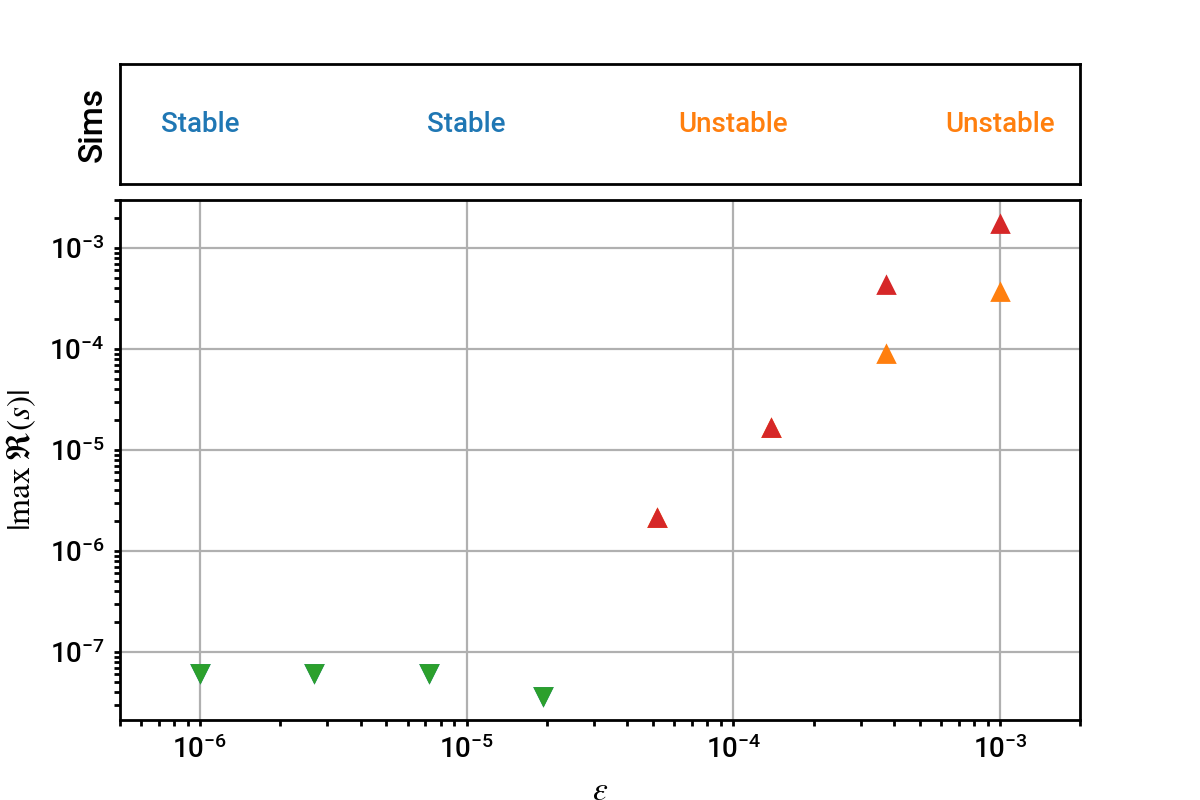

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [33]:
A = np.array(A_list)
smax = np.array(smax_list)
smax_sp = np.array(smax_sp_list)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.1,0.77,0.8,0.15])
ax1.text(1e-6, 0, "Stable", ha='center', va='center', color='C0')
ax1.text(1e-5, 0, "Stable", ha='center', va='center', color='C0')
ax1.text(1e-4, 0, "Unstable", ha='center', va='center', color='C1')
ax1.text(1e-3, 0, "Unstable", ha='center', va='center', color='C1')
ax1.set_xscale('log')
ax1.set_xlim(10**-6.3, 10**-2.7)
ax1.set_ylim(-1, 1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.minorticks_off()
ax1.set_ylabel("Sims")

ax2 = fig.add_axes([0.1,0.1,0.8,0.65])
ax2.plot(A[smax < 0], -smax_sp[smax_sp < 0], 'v')
ax2.plot(A[smax > 0], smax_sp[smax_sp > 0], '^')
ax2.plot(A[smax < 0], -smax[smax < 0], 'v')
ax2.plot(A[smax > 0], smax[smax > 0], '^')
ax2.set_xscale('log')
ax2.set_xlim(10**-6.3, 10**-2.7)
ax2.set_yscale('log')
ax2.grid()
ax2.set_xlabel(r'$\epsilon$')
ax2.set_ylabel(r'$|\max \; \Re(s)|$')

plt.tight_layout()

In [222]:
plt.savefig('coupled_growth.pdf')

2018-05-25 02:58:23,354 matplotlib.backends.backend_pdf 0/1 DEBUG :: Assigning font /b'F1' = '/Library/Fonts/Roboto-Medium.ttf'
2018-05-25 02:58:23,439 matplotlib.backends.backend_pdf 0/1 DEBUG :: Assigning font /b'F2' = '/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf'
2018-05-25 02:58:23,518 matplotlib.backends.backend_pdf 0/1 DEBUG :: Assigning font /b'F3' = '/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf'
2018-05-25 02:58:23,523 matplotlib.backends.backend_pdf 0/1 DEBUG :: Embedding font /Library/Fonts/Roboto-Medium.ttf.
2018-05-25 02:58:23,524 matplotlib.backends.backend_pdf 0/1 DEBUG :: Writing TrueType font.
2018-05-25 02:58:23,533 matplotlib.backends.backend_pdf 0/1 DEBUG :: Embedding font /usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf.
2018-05-25 02:58:23,534 matplotlib.backends.backend_pdf 0/1 DEBUG :: Writing TrueType font.
2018-05-25 02:58:23,542 matplotlib

In [57]:
smax_list

[-6.201897730139741e-08,
 -6.208160169813258e-08,
 -6.230419334541564e-08,
 -6.187423937453786e-08,
 -1.3923920345659548e-08,
 1.5452516828430207e-06,
 8.887346532633077e-06,
 8.060005012276874e-05,
 0.0005101574291328943,
 0.0017330888721325262]

## Self-coupling

In [109]:
krel = 0.5
ω = 6.43e-4

# Find index of positive mode
evals = shortmodes[krel][0]
freqs = 1j * evals
filt = gen_filt(1j*evals, krel)
filt_index_f = np.argmin(np.abs(freqs[filt].real - krel*param.ω_tide - ω))
freq_f = freqs[filt][filt_index_f]
print(freq_f)

# Find index of negative mode
evals = shortmodes[-krel][0]
freqs = 1j * evals
filt = gen_filt(1j*evals, -krel)
filt_index_b = np.argmin(np.abs(-freqs[filt].real - krel*param.ω_tide - ω))
freq_b = freqs[filt][filt_index_b]
print(freq_b)

# Build Q
def build_Q_self(A):
    Q = np.zeros((2,2), dtype=np.complex128)
    Q[0,0] = -1j * (freq_f - krel*param.ω_tide)
    Q[1,1] = -1j * (freq_b + krel*param.ω_tide)
    Q[0,1] = A * K_bLc_dict[(krel, -krel)][filt_index_f, filt_index_b]
    Q[1,0] = A * K_bLc_dict[(-krel, krel)][filt_index_b, filt_index_f]
    return Q

(0.014989827808875382-2.8359509540108117e-06j)
(-0.014989827808875382-2.8359509540108117e-06j)


In [122]:
A_range = np.linspace(8e-3, 9e-3, 100000)
growth = []
for A in A_range:
    Q = build_Q_self(A)
    freq = 1j * np.linalg.eigvals(Q)
    growth.append(np.max(freq.imag))

<IPython.core.display.Javascript object>


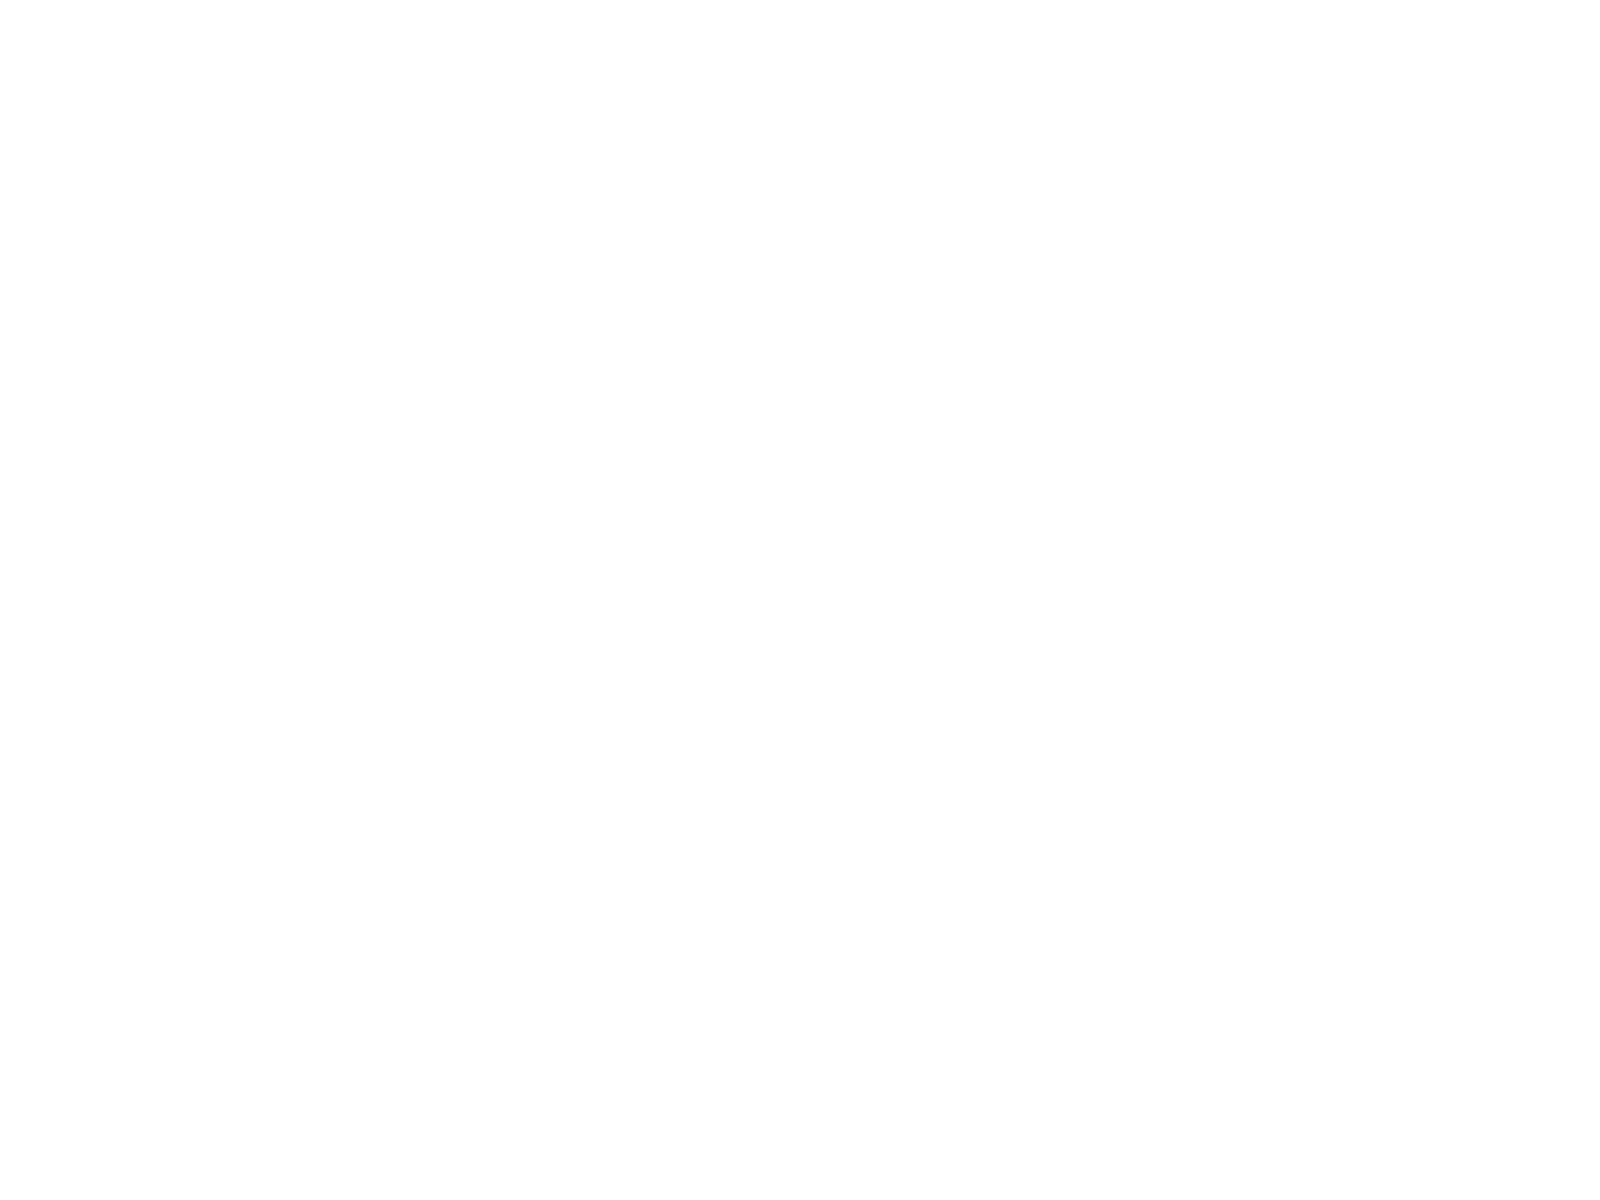

<IPython.core.display.Javascript object>


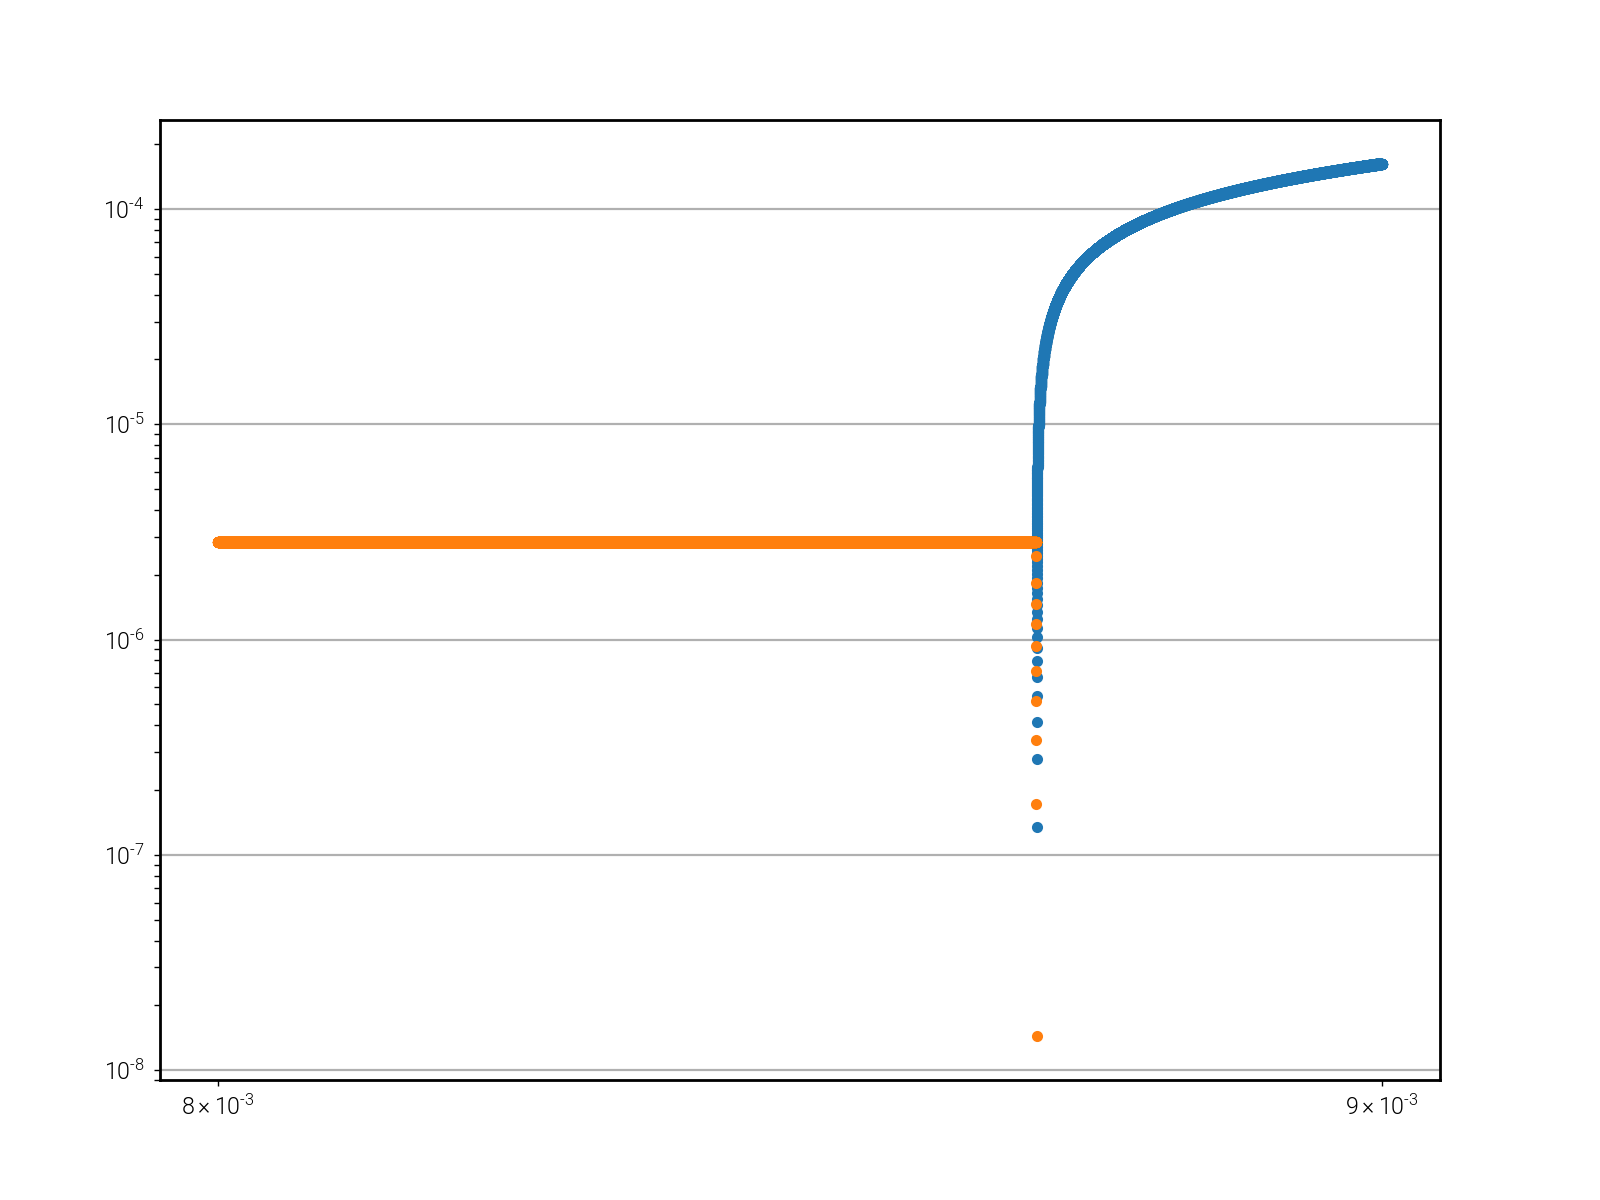

In [123]:
A = A_range
smax = np.array(growth)

plt.figure()
plt.figure()
plt.plot(A[smax > 0], smax[smax > 0], '.')
plt.plot(A[smax < 0], -smax[smax < 0], '.')
plt.xscale('log')
plt.yscale('log')
plt.grid()
#plt.plot(A_range, growth, '.-k')
#plt.xlabel('Amplitude')
#plt.ylabel('Growth rate')

<IPython.core.display.Javascript object>


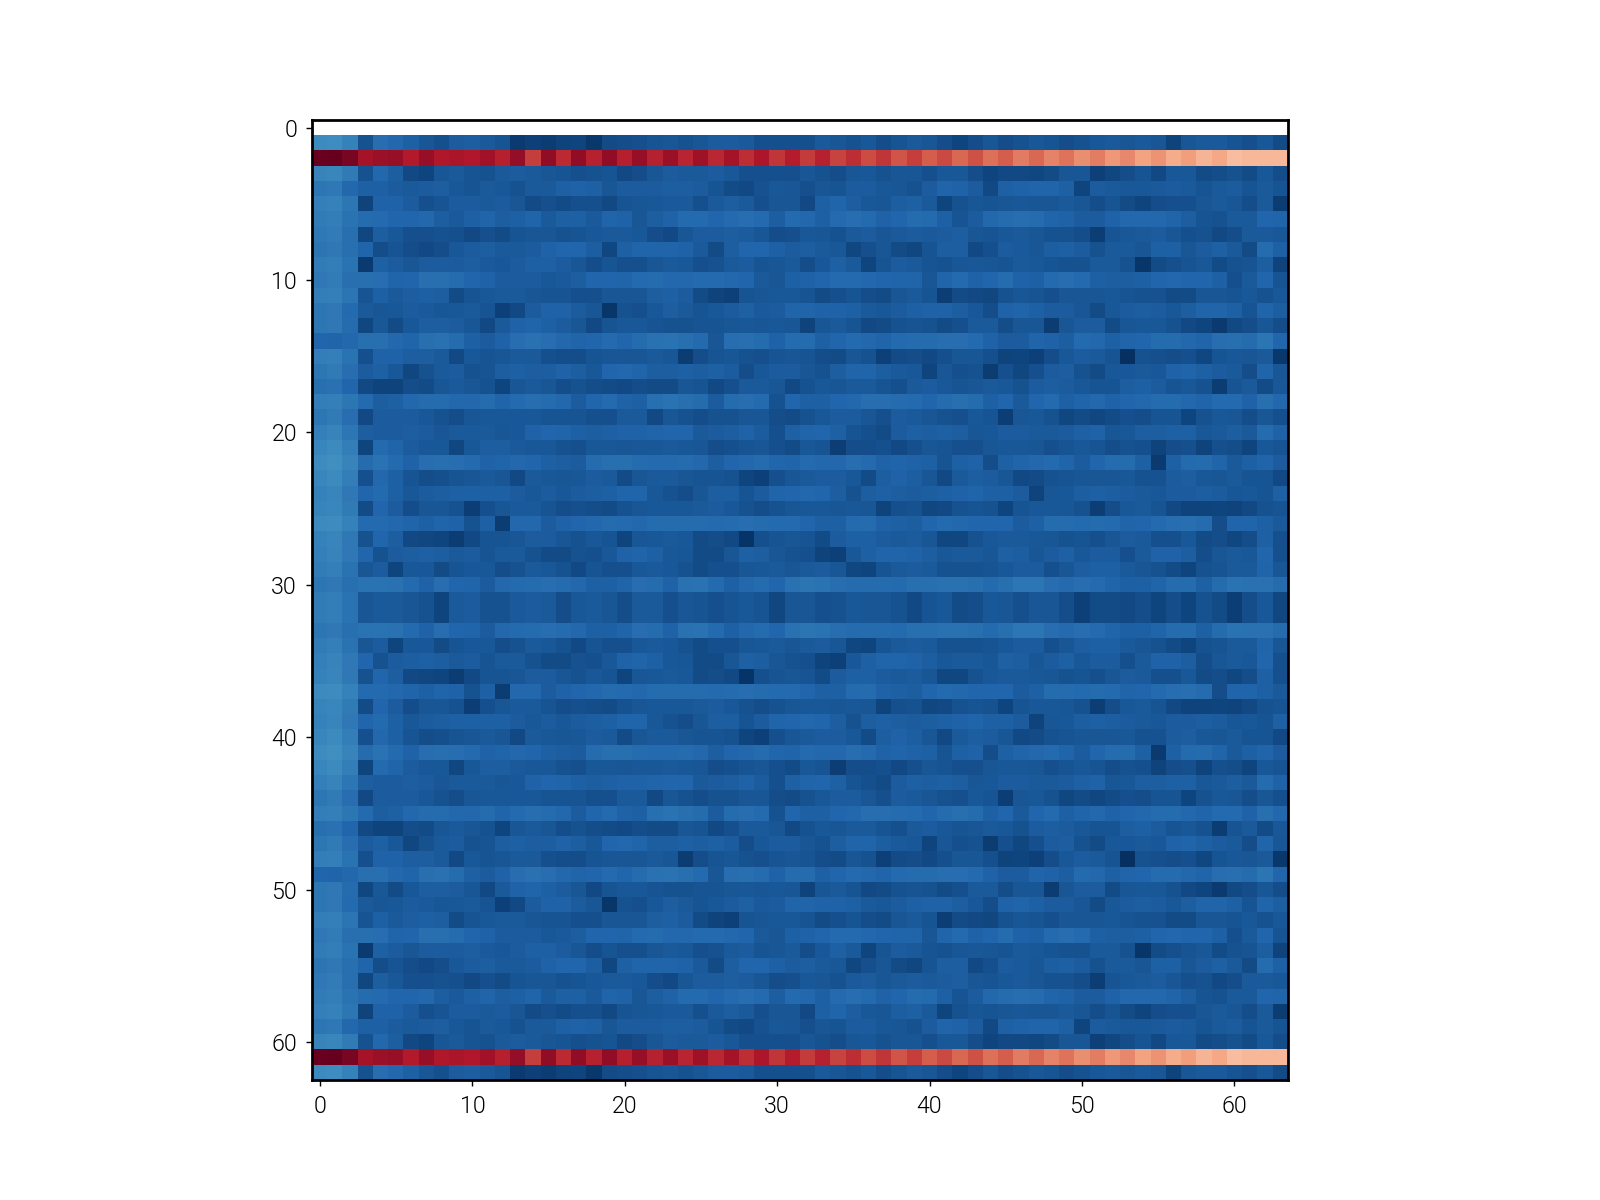

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [28]:
plt.figure()
plt.imshow(np.log10(np.abs(solver.state['p1']['c'])))

In [323]:
krel_b, krel_c

(1, 1)

In [27]:
solver_bvp.state.data

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [-2.74875079e-16+5.21320386e-17j,  2.11737227e-18-3.98806048e-19j,
         1.09655938e-19-1.68711202e-20j, ...,
        -1.08891258e-22+2.27834387e-21j,  1.35011105e-17-1.02794735e-17j,
         1.47161148e-19-1.93077882e-19j],
       [ 2.32132675e+00-3.82630916e-03j, -1.78554579e-02-1.41137860e-04j,
        -5.23319326e-05+1.09372640e-01j, ...,
         5.52590401e-08-6.91316875e-09j, -6.51814102e-05-2.47870458e-04j,
        -2.32238623e-06+6.07882518e-08j],
       ...,
       [ 1.30509792e-16+4.89215079e-17j, -1.00442476e-18-3.76563260e-19j,
        -7.93123517e-20-2.76397516e-21j, ...,
         6.37252307e-20+2.06693107e-20j, -1.32547889e-16+1.20990249e-16j,
        -8.25641513e-18-1.86154692e-18j],
       [ 2.32132675e+00+3.82630916e-03j, -1.

In [80]:
import time
import multiprocessing
from multiprocessing import Pool

def poolfunc(x):
    proc = multiprocessing.current_process()
    tqdm_kw = {'leave': True}
    save_coupling(*x, tqdm_kw=tqdm_kw)

try:
    pool.close()
    pool.join()
except NameError:
    pass


N = 8
pool = Pool(N)
pool_args = list(zip(itertools.repeat(1), np.arange(-5,6)))
pool.imap_async(poolfunc, [(1,-5),(1,-4),(1,-3),(1,-2),(1,-1),(1,0),(1,1),(1)])
pool.close()

Saving coupling krel_b=1.0 krel_c=-5.0
Saving coupling krel_b=1.0 krel_c=-4.0
Saving coupling krel_b=1.0 krel_c=-3.0
Saving coupling krel_b=1.0 krel_c=1.0
Saving coupling krel_b=1.0 krel_c=-1.0
Saving coupling krel_b=1.0 krel_c=0.0
Saving coupling krel_b=1.0 krel_c=-2.0


In [70]:
pool.join()